In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize
from functools import partial
import pyabc
from pyabc.visualization import plot_kde_2d, plot_data_callback
import os
import tempfile
import scipy.stats as st

In [24]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [25]:
plt.rcParams["figure.figsize"] = (14,6)

In [26]:
data = pd.read_hdf("../data/ts-covid-provinces.hdf", key="China")
data = data["Hunan"]
data = data.drop(columns="C")
data

Province   Anhui              Beijing              Chongqing     ... Xinjiang  \
               C  D    I    R       C  D    I    R         C  D  ...        I   
date                                                             ...            
2020-01-28    42  0   42    0      50  0   48    1        59  0  ...        3   
2020-01-29    64  0   64    0      64  0   61    2        79  0  ...        5   
2020-01-30    91  0   91    0      77  0   74    2       104  0  ...        7   
2020-01-31   123  0  122    1      92  0   88    3       130  0  ...        9   
2020-02-01   160  0  158    1     110  0  105    4       157  0  ...       11   
...          ... ..  ...  ...     ... ..  ...  ...       ... ..  ...      ...   
2020-06-05   991  6    0  985     593  9    2  581       579  6  ...        0   
2020-06-06   991  6    0  985     593  9    2  582       579  6  ...        0   
2020-06-07   991  6    0  985     593  9    2  582       579  6  ...        0   
2020-06-08   991  6    0  985     593  9    2  582       579  6  ...        0   
2020-06-09   991  6    0  985     594  9    1  583       579  6  ...        0   

Province       Yunnan             Zhejiang                
             R      C  D   I    R        C  D    I     R  
date                                                      
2020-01-28   0     15  0  15    0       78  0   77     1  
2020-01-29   0     22  0  22    0      119  0  117     1  
2020-01-30   0     32  0  32    0      176  0  174     2  
2020-01-31   0     43  0  43    0      247  0  243     3  
2020-02-01   0     55  0  54    0      323  0  317     6  
...         ..    ... ..  ..  ...      ... ..  ...   ...  
2020-06-05  73    185  2   0  183     1268  1    0  1267  
2020-06-06  73    185  2   0  183     1268  1    0  1267  
2020-06-07  73    185  2   0  183     1268  1    0  1267  
2020-06-08  73    185  2   0  183     1268  1    0  1267  
2020-06-09  73    185  2   0  183     1268  1    0  1267  

[134 rows x 132 columns]

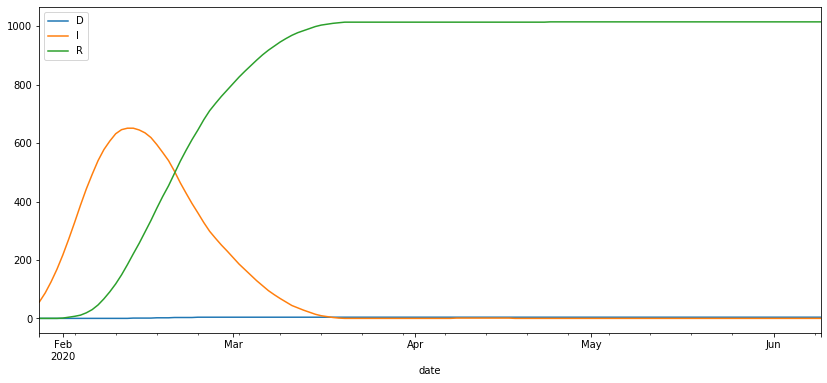

In [29]:
data.plot();

In [30]:
data["R"] = data["R"] + data["D"]
data = data.drop(columns=["D"])

In [31]:
train = data[:"2020-04-01"].copy()
test = data["2020-04-02":].copy()

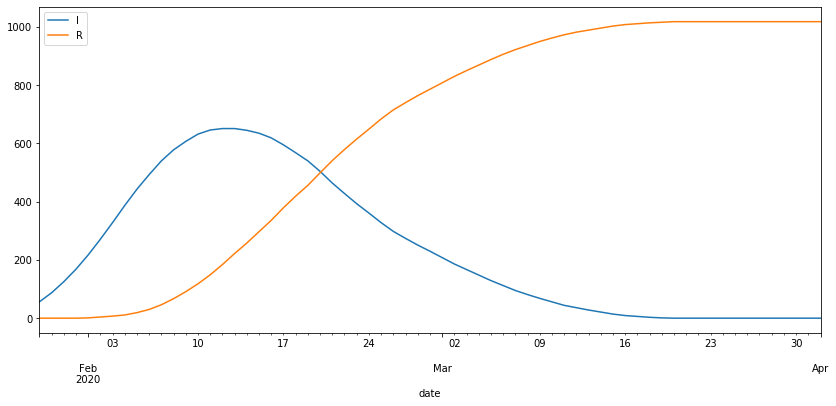

In [32]:
train.plot();

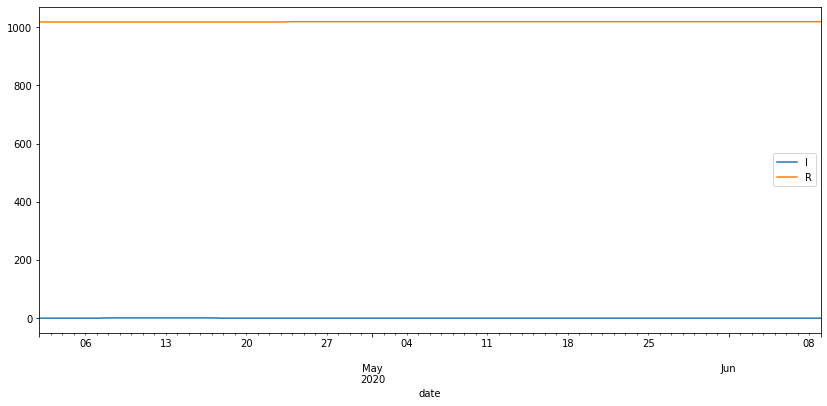

In [33]:
test.plot();

In [34]:
def SIR(t, y, p):
    I, R = y
    S = p["pop"] - I - R
    #dS = -p["beta"] * S * I / p["pop"]
    dI = p["beta"] * S * I / p["pop"] - p["gamma"] * I
    dR = p["gamma"] * I
    return dI, dR 

In [35]:
def build_model(deqn, y0, t):
    def model(p):
        output = solve_ivp(deqn, t_span=(0,t), y0=y0, args=(p,), t_eval=np.arange(0,t,1))
        simulation = pd.DataFrame(data=output.y.T, index=output.t, columns=["I", "R"])
        return simulation
    return model

In [36]:
def distance(simulation, obs):
    sqd = (obs["I"] - simulation["I"])**2 + (obs["R"] - simulation["R"])**2
    return np.sqrt(sqd.sum())

In [37]:
y0 = train.head(1).to_numpy().flatten()
y0

array([56,  0], dtype=int64)

In [38]:
model = build_model(SIR, y0, len(train))

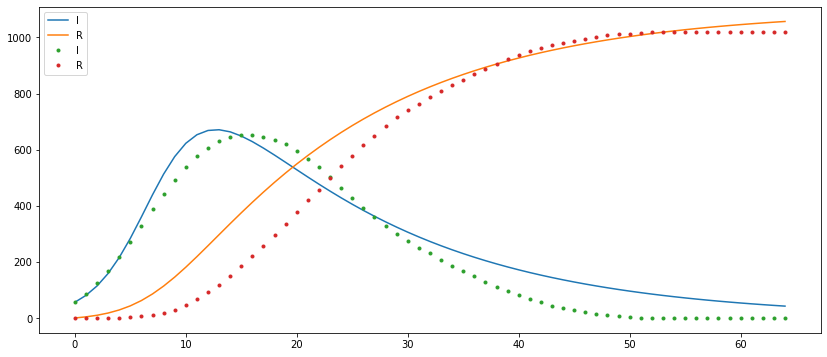

In [39]:
params = {"pop": 1.1e3, "beta":0.45, "gamma":1/17}
simulation = model(params)

ax=simulation.plot()
train.reset_index(drop=True).plot(ax=ax, style=".")

In [40]:
prior = pyabc.Distribution(
    beta=pyabc.RV("uniform", 0.2, 0.6),
    gamma=pyabc.RV("uniform", 0, 0.2),
    pop=pyabc.RV("uniform", 5e2, 1.5e3)
)

In [41]:
abc = pyabc.ABCSMC(
    models=model,
    parameter_priors=prior,
    distance_function=distance,
    #population_size=50,
    #transitions=pyabc.LocalTransition(k_fraction=.3),
    eps=pyabc.MedianEpsilon()
)

In [42]:
abc.new(db_path, train.to_dict("list"))

INFO:History:Start <ABCSMC(id=1, start_time=2020-08-02 15:42:30.018056, end_time=None)>


In [43]:
h = abc.run(min_acceptance_rate=0.01)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 3371.7931663447202
INFO:ABC:t: 0, eps: 3371.7931663447202.
INFO:ABC:Acceptance rate: 100 / 183 = 5.4645e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 2499.0357146161477.
INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01, ESS=6.1270e+01.
INFO:ABC:t: 2, eps: 1919.1636398844544.
INFO:ABC:Acceptance rate: 100 / 291 = 3.4364e-01, ESS=9.4307e+01.
INFO:ABC:t: 3, eps: 1581.3174842660515.
INFO:ABC:Acceptance rate: 100 / 214 = 4.6729e-01, ESS=8.5661e+01.
INFO:ABC:t: 4, eps: 1341.981570274521.
INFO:ABC:Acceptance rate: 100 / 217 = 4.6083e-01, ESS=9.2150e+01.
INFO:ABC:t: 5, eps: 1158.9229311229312.
INFO:ABC:Acceptance rate: 100 / 204 = 4.9020e-01, ESS=9.3196e+01.
INFO:ABC:t: 6, eps: 1007.6711502875112.
INFO:ABC:Acceptance rate: 100 / 228 = 4.3860e-01, ESS=9.0126e+01.
INFO:ABC:t: 7, eps: 913.0934107179917.
INFO:ABC:Acceptance rate: 100 / 209 = 4.7847e-01, ESS=8.3119e+01.
INFO:ABC:t: 8, eps: 853.0336752521579.
INFO:ABC:Acceptance rate

INFO:ABC:t: 77, eps: 739.8352087987936.
INFO:ABC:Acceptance rate: 100 / 199 = 5.0251e-01, ESS=9.4903e+01.
INFO:ABC:t: 78, eps: 739.835208772835.
INFO:ABC:Acceptance rate: 100 / 216 = 4.6296e-01, ESS=8.9223e+01.
INFO:ABC:t: 79, eps: 739.8352087500159.
INFO:ABC:Acceptance rate: 100 / 231 = 4.3290e-01, ESS=6.7000e+01.
INFO:ABC:t: 80, eps: 739.8352087337042.
INFO:ABC:Acceptance rate: 100 / 235 = 4.2553e-01, ESS=8.9703e+01.
INFO:ABC:t: 81, eps: 739.8352087222996.
INFO:ABC:Acceptance rate: 100 / 203 = 4.9261e-01, ESS=8.1028e+01.
INFO:ABC:t: 82, eps: 739.8352087109984.
INFO:ABC:Acceptance rate: 100 / 270 = 3.7037e-01, ESS=9.4816e+01.
INFO:ABC:t: 83, eps: 739.8352087036582.
INFO:ABC:Acceptance rate: 100 / 267 = 3.7453e-01, ESS=9.0727e+01.
INFO:ABC:t: 84, eps: 739.8352086972618.
INFO:ABC:Acceptance rate: 100 / 244 = 4.0984e-01, ESS=8.9644e+01.
INFO:ABC:t: 85, eps: 739.8352086927239.
INFO:ABC:Acceptance rate: 100 / 251 = 3.9841e-01, ESS=8.7137e+01.
INFO:ABC:t: 86, eps: 739.8352086896198.
INFO:AB

In [44]:
params = h.get_distribution()[0].mean().to_dict()
params

{'beta': 0.37375224050777267,
 'gamma': 0.06273087758315837,
 'pop': 1079.732813201131}

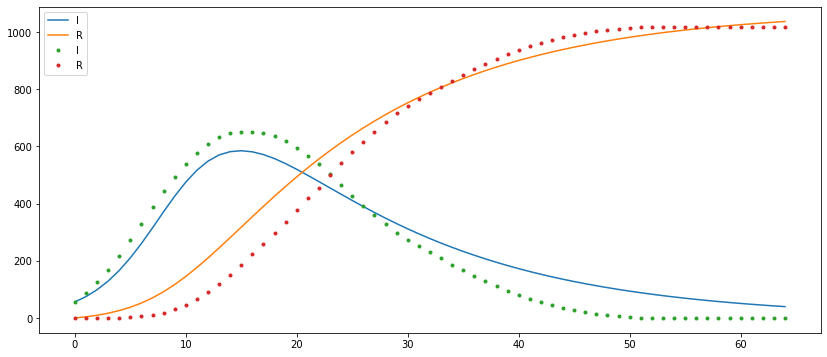

In [45]:
simulation = model(params)

ax=simulation.plot()
train.reset_index(drop=True).plot(ax=ax, style=".")

In [46]:
test_model = build_model(SIR, y0, len(train)+len(test))

In [47]:
simulation = test_model(params)
simulation.index = data.index

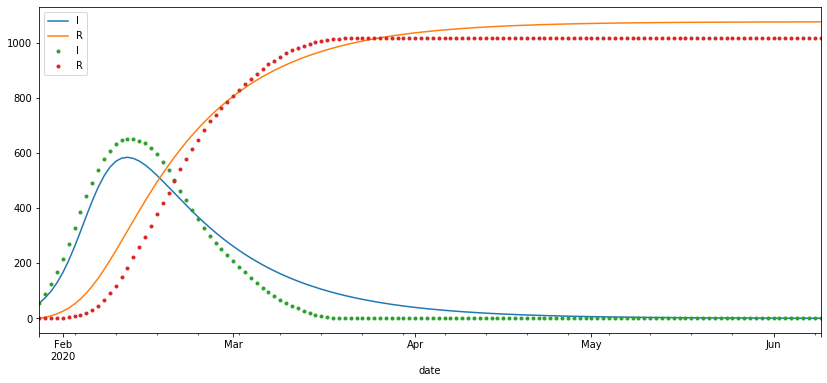

In [48]:
ax = simulation.plot()
data.plot(ax=ax, style=".")